# Table of Contents
1. [Author](#author)
2. [Introduction](#introduction)
3. [Packages and Import](#packages-and-import)
4. [Evaluation Functions](#evaluation-functions)
6. [EDA and Technical Analysis](#eda-and-technical-analysis)
7. [Train-Test Split](#train-test-split)
8. [Logistic Regression](#logistic-regression)
9. [K-Nearest Neighbors](#k-nearest-neighbors)
10. [Decision Tree](#decision-tree)
11. [Random Forest](#random-forest)
11. [AdaBoost](#adaboost)
11. [XGBoost](#xgboost)
11. [Model Evaluation](#model-evaluation)
11. [Conclusions](#conclusions)

# Author

Sergio Sanz

# Introduction
<a id='introduction'><a>
    
## Objective
This machine-learning challenge focuses on **analyzing** the Kaggle "Pima Indians Diabetes Database" and **predicting** whether a patient has Diabetes or not. For this purpose, serveral machine-learning classifiers will be used and compared to each other in terms of ROC AUC and F1 scores, and generalization capacity.
    
The evaluated models include: **Logistic Regression**, **K-Nearest Neighbors (KNN)**, **Decision Tree**, **Random Forest**, **AdaBoost**, and **XGBoost**.

## Context
The dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

## About the dataset
The dataset consists of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. For the outcome class value 1 is interpreted as "tested positive for diabetes".

|Column Name| Description|
|:------------|:------------|
|Pregnancies|Number of times pregnant|
|Glucose|Plasma glucose concentration a 2 hours in an oral glucose tolerance test|
|BloodPressure|Diastolic blood pressure (mm Hg)|
|SkinThickness|Triceps skin fold thickness (mm)|
|Insulin|2-Hour serum insulin (mu U/ml)|
|BMI|Body mass index (weight in kg/(height in m)^2)|
|DiabetesPedigreeFunction| Diabetes pedigree function|
|Age| Age (years)|
|Outcome|Class variable (0 or 1) |


For more information about the dataset, click here: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database


# Packages and Import
<a id='packages-and-import'><a>

In [1]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

## Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

## Imputation
from sklearn.impute import SimpleImputer, KNNImputer

## Feature-scaling stack
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, OneHotEncoder

# Machine-learning stack
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score, fbeta_score, f1_score
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (8, 6)

In [2]:
df_database = pd.read_csv("./data/data.csv")

# Evaluation Functions
<a id='evaluation-functions'><a>

In [3]:
def predict_and_print_scores(model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,                             
                             training=True,
                             test=True,
                             accuracy=True,
                             recall=True,
                             precision=True,
                             fbeta=[True, 1.0],
                             roc_auc=True,
                             matrix=True,
                             figsize=(3,2),
                             cmap='YlGn'):
    
    '''
    Given an already trained model, this function predicts and print some performance scores training and/or testing data.
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model             Trained model
    X_train           Training data with features
    y_train           Traning data with labels or targets
    X_test            Testing data with features
    y_test            Testind data with labels or targets                             
    training=True     True: print scores on the traning set
    test=True         True: print scores on the testing set
    accuracy=True     True: print accuracy_score()
    recall=True       True: print recall_score()
    precision=True    True: print precision_score()
    fbeta=[True, 1.0] [True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True      True: print roc_auc_score()
    matrix=True       True: plot confusion matrix
    figsize=(3,2)     Figure size for the confusion matrix
    cmap='YlGn')      Color map for the confusion matrix
    
    Posible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns: fig, ax: the figure objects of the cunfusion matrix (if enabled)
    '''

    # Prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
            
    # Scores
    if accuracy:
        if training:
            print("Accuracy on training set:", round(accuracy_score(y_train, y_pred_train), 2))
        if test:
            print("Accuracy on test set:", round(accuracy_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if recall:        
        if training:
            print("Recall on training set:", round(recall_score(y_train, y_pred_train), 2))
        if test:
            print("Recall on test set:", round(recall_score(y_test, y_pred_test), 2))
        print("--------"*5)
    
    if precision:
        if training:
            print("Precision on training set:", round(precision_score(y_train, y_pred_train), 2))
        if test:
            print("Precision on test set:", round(precision_score(y_test, y_pred_test), 2))
        print("--------"*5)

    if fbeta[0]:
        if training:
            print("fbeta_score on training set:", round(fbeta_score(y_train, y_pred_train, beta=fbeta[1]), 2))
        if test:
            print("fbeta_score on test set:", round(fbeta_score(y_test, y_pred_test, beta=fbeta[1]), 2))
        print("--------"*5)

    if roc_auc:
        y_pred_train_p = model.predict_proba(X_train)[:,1]
        y_pred_test_p = model.predict_proba(X_test)[:,1]
        if training:
            print('roc_auc_score on trainig set: ', round(roc_auc_score(y_train, y_pred_train_p), 2))
        if test:
            print('roc_auc_score on test set: ', round(roc_auc_score(y_test, y_pred_test_p), 2))
        print("--------"*5)
    
    # Plot confusion matrix 
    if matrix:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cmap=cmap);
        plt.title('Test Set')
        plt.ylabel('True label')
        plt.xlabel('Predicted label')                 
        
def train_crossval_predict_score(model,
                                 hyperparams,
                                 X_train,
                                 y_train,
                                 X_test,
                                 y_test,
                                 cv=5,
                                 scoring='accuracy',
                                 verbose=0,
                                 n_jobs=-1,
                                 cross_val='full',
                                 random_state='None',
                                 training=True,
                                 test=True,
                                 accuracy=True,
                                 recall=True,
                                 precision=True,
                                 fbeta=[True, 1.0],
                                 roc_auc=True,
                                 matrix=True,
                                 figsize=(3,2),
                                 cmap='YlGn'):
                                 
    '''
    Given an instantiated model, this function trains, cross-validate, predicts, and prints some performance scores training and/or testing data.
    The cross-validation strategy is selected with the input parametes "cross_val".
    The supported metrics are: accuracy, recall, precision, fbeta_score (and f1_score if beta = 1.0), roc_auc.
    If the input parameter "matrix" is set to True, the function plot the confusion matrix with a color map given in "cmap".

    model                 #Instantiated model
    hyperparams           #Dictionary incluing hyperparameters
    X_train               #Training data with features
    y_train               #Traning data with labels or targets
    X_test                #Testing data with features
    y_test                #Testind data with labels or targets
    cv=5                  #Number of cross-validdation folds
    scoring='accuracy'    #Scoring method
    verbose=0             #Verbose
    n_jobs=-1             #Number of jobs in parallel
    cross_val='full'      #'Full'/'full': Apply GridSearchCV. 'Random'/'random': Apply RandomSearchCV
    random_state          #Random state parameter for RandomSearchCV: 'None' or an integer
    training=True         #True: print scores on the traning set
    test=True             #True: print scores on the testing set
    accuracy=True         #True: print accuracy_score()
    recall=True           #True: print recall_score()
    precision=True        #True: print precision_score()
    fbeta=[True, 1.0]     #[True, beta]: print fbeta_score. If beta = 1.0: f1_score
    roc_auc=True          #True: print roc_auc_score()
    matrix=True           #True: plot confusion matrix
    figsize=(3,2)         #Figure size for the confusion matrix
    cmap='YlGn'):         #Color map for the confusion matrix

    Posible color maps: 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                        'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                        'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'
    
    Returns:
    - best_model: object of the best model after cross-validation
    - best_params: hyperparameters of the best model
    - fig, ax: the figure objects of the cunfusion matrix (if enabled)
'''

    # Cross-validation
    if cross_val == 'Full' or cross_val == 'full':
        grid_model = GridSearchCV(model, param_grid=hyperparams, cv=cv, scoring=scoring, verbose=verbose, n_jobs=n_jobs)
    elif cross_val == 'Random' or cross_val == 'random':        
        grid_model = RandomizedSearchCV(model, param_distributions=hyperparams, cv=cv, scoring=scoring, random_state=random_state, verbose=verbose, n_jobs=n_jobs)
        
    # Fit
    grid_model.fit(X_train, y_train)
    best_model = grid_model.best_estimator_
    best_params = grid_model.best_params_
    print('Best params:', grid_model.best_params_)
    print("--------"*5)
    
    # Predict and print results
    predict_and_print_scores(best_model,
                             X_train,
                             y_train,
                             X_test,
                             y_test,
                             training=training,
                             test=test,
                             accuracy=accuracy,
                             recall=recall,
                             precision=precision,
                             fbeta=fbeta,
                             roc_auc=roc_auc,
                             matrix=matrix,
                             figsize=figsize,
                             cmap=cmap)
    
    return best_model, best_params


def find_roc_threshold_tpr(model, X, y, value_target):
    
    """
    This function calculates the threshold and false positive rate corresponding to a true positive rate of value_target (from 0 to 1).
    
    model                 # Trained model
    X                     # Feature dataset
    y                     # Target dataset
    value_target          # True positive rate value
    
    Returns:
    
    threshold             # Threshold value
    false_positive_rate   # False positive rate value
    """

    fpr, tpr, thr = roc_curve(y, model.predict_proba(X)[:,1])

    old_diff = 100000000
    for index, value in enumerate(tpr):
        new_diff = abs(value_target - value)
        if new_diff < old_diff:
            false_pos_rate = fpr[index]
            threshold = thr[index]
            old_diff = new_diff

    return threshold, false_pos_rate

def find_roc_threshold_f1(model, X, y):
    
    """
    This function calculates the threshold in the ROC curve that maximizes the f1 score.
    model                 # Trained model
    X                     # Feature dataset
    y                     # Target dataset
    
    Returns:
    
    best_threshold        # Threshold value
    best_f1_score         # False positive rate value
    
    """
    
    pred_ = model.predict_proba(X)[:,1]

    best_threshold = 0.5
    best_f1_score = 0.0
    for value in np.arange(1, 10, 0.5):
        pred_tmp = np.where(pred_ >= float(value/10), 1, 0)
        cost = f1_score(y, pred_tmp)
        if cost > best_f1_score:
            best_f1_score = cost
            best_threshold = float(value/10)
      
    return best_threshold, best_f1_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    # Confusion matrix
    #cm = confusion_matrix(test_labels, rf_predictions)
    #plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
    #                      title = 'Health Confusion Matrix')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the confusion matrix
    plt.figure(figsize = figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 18)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 18,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    plt.show()

# EDA and Technical Analysis
<a id='eda-and-technical-analysis'><a>

In [4]:
df_copy = df_database.copy()

In [5]:
df_copy.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Data size
df_copy.shape

(768, 9)

In [7]:
# Statistics
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [8]:
# Type of the features
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
# Convert column names to lowercase
df_copy.columns = [x.lower() for x in df_copy.columns]

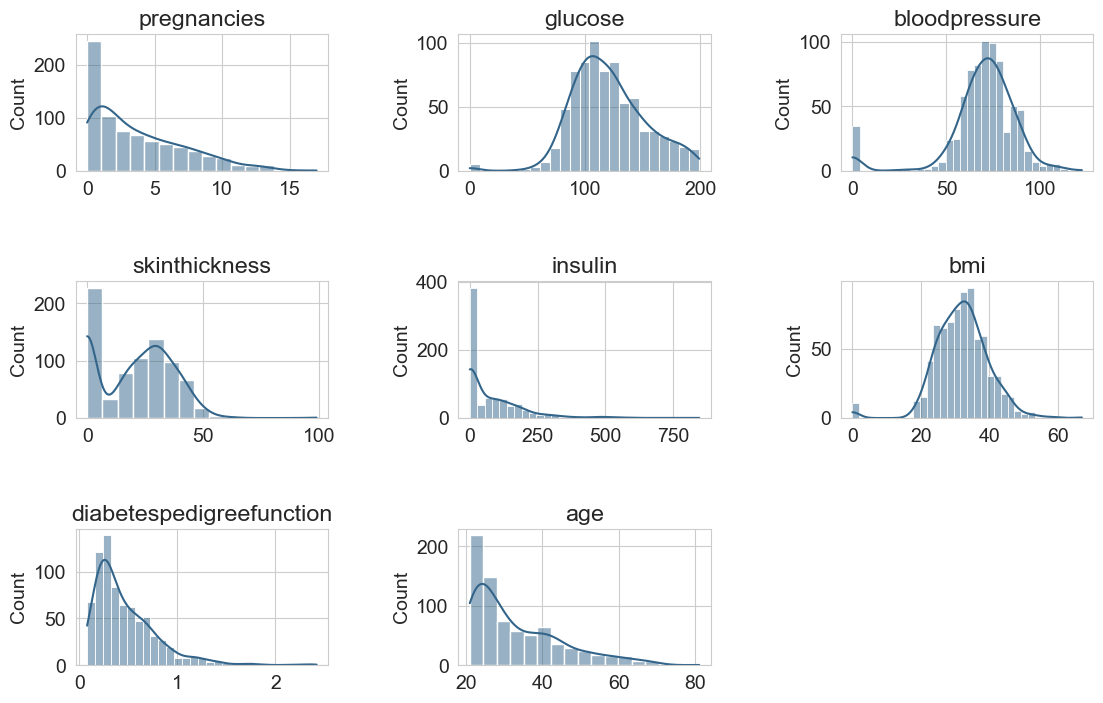

In [10]:
# Plot distributions
fig,ax = plt.subplots(3,3,figsize=(12,8))
count = 0
for item in df_copy.columns.to_list():
    sns.histplot(df_copy[item], kde=True, ax=ax[int(count/3)][count%3], color='#33658A').set(title=item, xlabel='')
    count += 1
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=3)

In [11]:
# Determine the number of zero values to be replaced with NaN
print("Total number of rows: ", len(df_copy))
print("Number of rows missing insulin: ", format(len(df_copy.loc[df_copy['insulin']== 0])))
print("Number of rows missing bmi: ", format(len(df_copy.loc[df_copy['bmi']== 0])))
print("Number of rows missing bloodpressure: ", format(len(df_copy.loc[df_copy['bloodpressure']== 0])))
print("Number of rows missing glucose: ", format(len(df_copy.loc[df_copy['glucose']== 0])))
print("Number of rows missing skinthickness: ", format(len(df_copy.loc[df_copy['skinthickness']== 0])))
print("Number of rows missing diabetespedigreefunction: ", format(len(df_copy.loc[df_copy['diabetespedigreefunction']== 0])))
print("Number of rows age: ", format(len(df_copy.loc[df_copy['age']== 0])))
print("Number of rows pregnancies: ", format(len(df_copy.loc[df_copy['pregnancies']== 0])))

Total number of rows:  768
Number of rows missing insulin:  374
Number of rows missing bmi:  11
Number of rows missing bloodpressure:  35
Number of rows missing glucose:  5
Number of rows missing skinthickness:  227
Number of rows missing diabetespedigreefunction:  0
Number of rows age:  0
Number of rows pregnancies:  111


In [12]:
#Replace zeros with nan
df = df_copy.copy()
df.insulin.replace(0, np.nan, inplace=True)
df.bmi.replace(0, np.nan, inplace=True)
df.bloodpressure.replace(0, np.nan, inplace=True)
df.glucose.replace(0, np.nan, inplace=True)
df.skinthickness.replace(0, np.nan, inplace=True)

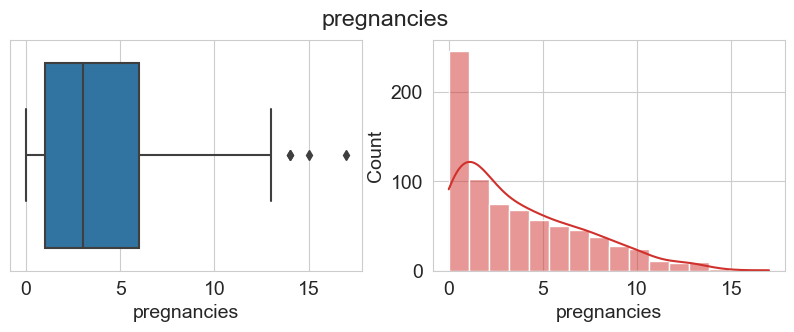

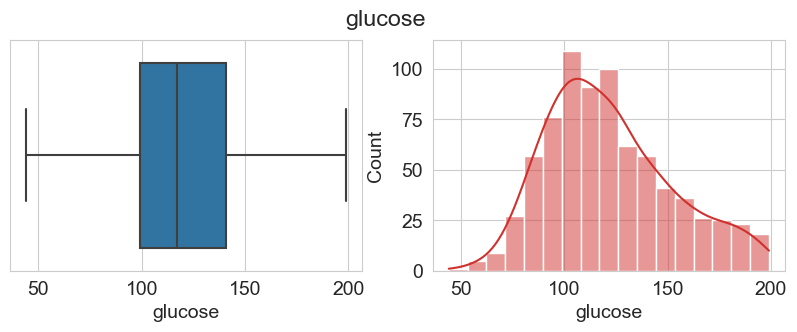

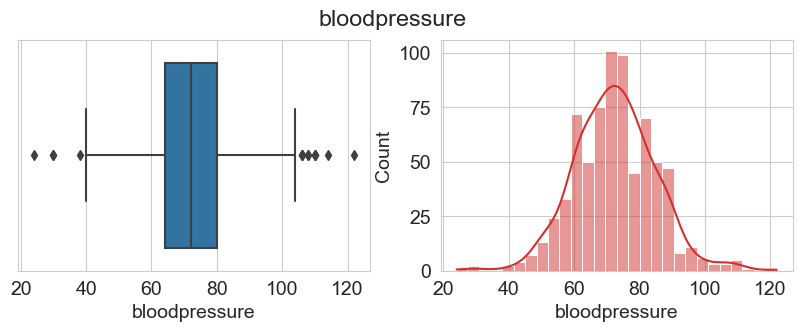

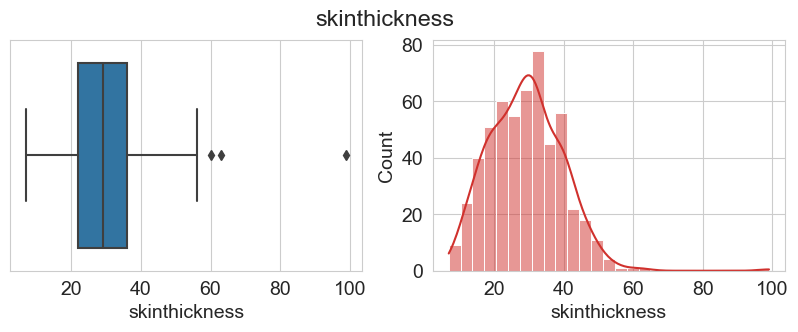

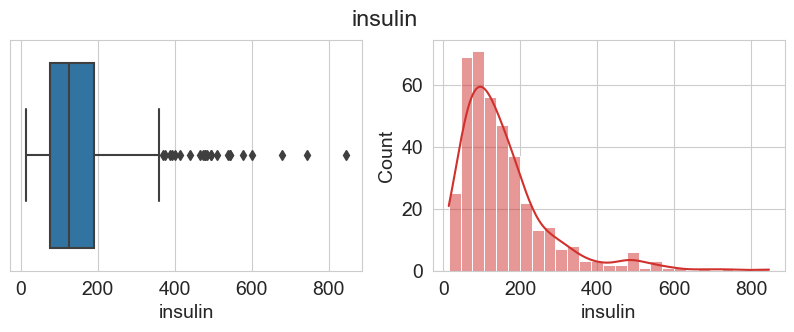

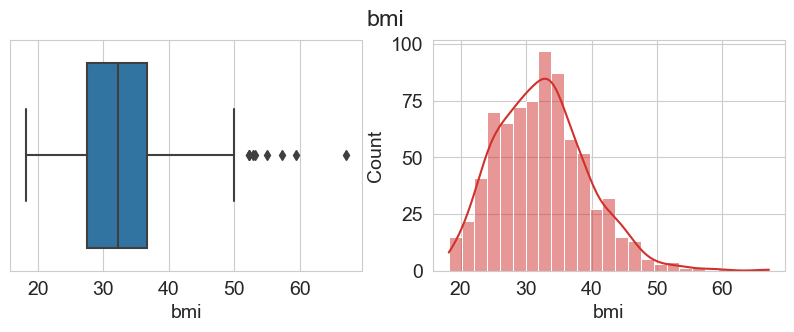

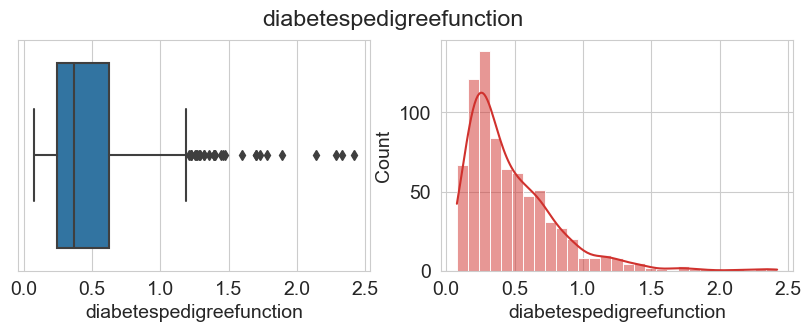

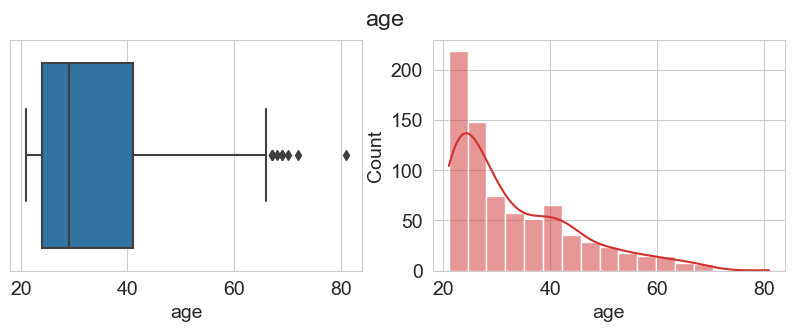

In [13]:
# Investigate possible outliers and skeewness 
num_features = list(df.columns[df.dtypes!=object])
num_features.remove('outcome')

def plot_num(feature):
    fig,axes=plt.subplots(1,2)
    sns.boxplot(data=df, x=feature, ax=axes[0])
    sns.histplot(data=df, x=feature, ax=axes[1], color='#D0312D', kde=True)
    fig.set_size_inches(10, 3)
    plt.suptitle(feature)  # Adds a title to the entire figure
    plt.show()
    
for column in num_features:
    plot_num(column)

According to the above plots, the distributions of the following features are skeweed: Age, pregnancies, bmi, insulin, diabetespedigrifunction, skinthickness.

In [14]:
# Create new columns with the log function in order to fix skeewness
log_features_preg = df[['pregnancies']].apply(lambda x : np.log(x + 1))
log_features_rest = df[['age', 'bmi', 'insulin', 'diabetespedigreefunction', 'skinthickness']].apply(lambda x : np.log(x))
log_features = pd.concat([log_features_preg, log_features_rest], axis=1)
log_features.columns = ['log_pregnancies', 'log_age', 'log_bmi', 'log_insulin', 'log_diabetespedigreefunction','log_skinthickness']

In [15]:
# Convert age into categorical
series_age_grouped = pd.qcut(df['age'], q=10)
series_age_grouped_sorted = sorted(series_age_grouped.unique())
age_cat = pd.CategoricalDtype(categories=series_age_grouped_sorted, ordered=True)
df_age_grouped = pd.DataFrame(series_age_grouped)
df_age_grouped = df_age_grouped.astype(age_cat)
df_age_grouped.columns = ['cat_age']
df_age_grouped = df_age_grouped.astype(str)

interval_to_str = {
    '(20.999, 22.0]': '20-22',
    '(22.0, 23.0]': '22-23',
    '(23.0, 25.0]': '23-25',
    '(25.0, 27.0]': '25-27',
    '(27.0, 29.0]': '27-29',
    '(29.0, 33.0]': '29-33',
    '(33.0, 38.0]': '33-38',
    '(38.0, 42.6]': '38-42.6',
    '(42.6, 51.0]': '42.6-51',
    '(51.0, 81.0]': '51-81'
}

# Convert intervals to string representations
df_age_grouped['cat_age'] = df_age_grouped['cat_age'].map(interval_to_str)
series_age_grouped_sorted = sorted(df_age_grouped['cat_age'].unique())
age_cat = pd.CategoricalDtype(categories=series_age_grouped_sorted, ordered=True)
df_age_grouped['cat_age'] = df_age_grouped['cat_age'].astype(age_cat)

In [16]:
# Join the new columns
df2 = pd.concat([df, log_features, df_age_grouped], axis=1)

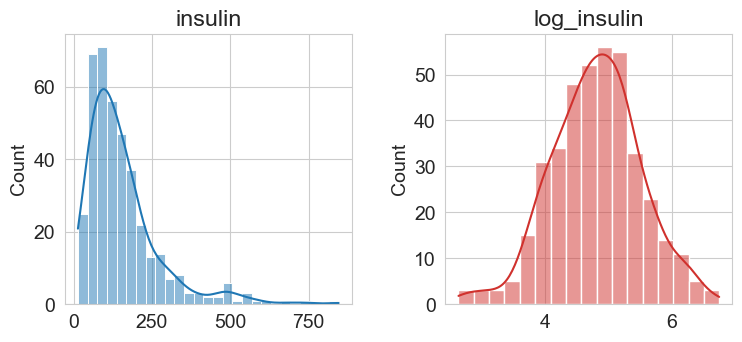

In [17]:
# Result after skeewness correction (e.g. insulin)
fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(121)
sns.histplot(df2['insulin'], kde=True, ax=ax1).set(title='insulin', xlabel='')
ax2 = fig.add_subplot(122)
sns.histplot(df2['log_insulin'], kde=True, ax=ax2, color='#D0312D').set(title='log_insulin', xlabel='')
ax.flat[-1].set_visible(False)
fig.tight_layout(pad=2)

In [18]:
# Display info
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   pregnancies                   768 non-null    int64   
 1   glucose                       763 non-null    float64 
 2   bloodpressure                 733 non-null    float64 
 3   skinthickness                 541 non-null    float64 
 4   insulin                       394 non-null    float64 
 5   bmi                           757 non-null    float64 
 6   diabetespedigreefunction      768 non-null    float64 
 7   age                           768 non-null    int64   
 8   outcome                       768 non-null    int64   
 9   log_pregnancies               768 non-null    float64 
 10  log_age                       768 non-null    float64 
 11  log_bmi                       757 non-null    float64 
 12  log_insulin                   394 non-null    floa

<Axes: title={'center': 'Outcome'}, xlabel='outcome', ylabel='count'>

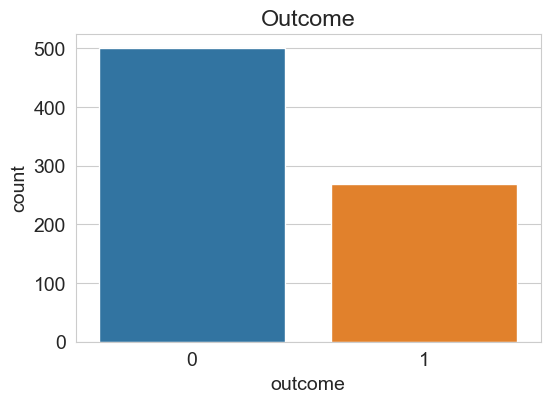

In [19]:
# Plotting the target variable: moderately imbalanced, but not critical
fig, ax = plt.subplots(figsize=(6,4))
plt.title('Outcome')
sns.countplot(x=df2.outcome)

# Train-Test Split
<a id='train-test-split'><a>

In [20]:
# Define predictors and target variable
X = df2.drop(['outcome'], axis=1)
y = df2['outcome']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 768 observations in our dataset and 15 features
Our target vector has also 768 values


In [21]:
# Split into train and test set 
X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
print('X_train shape:', X_train_all.shape)
print('X_test shape:', X_test_all.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (614, 15)
X_test shape: (154, 15)
y_train shape: (614,)
y_test shape: (154,)


# Logistic Regression
<a id='logistic-regression'><a>

In [23]:
X_train_logcat= X_train_all[['log_pregnancies', 'log_bmi', 'log_insulin', 'glucose', 'bloodpressure', 'log_diabetespedigreefunction', 'log_skinthickness', 'cat_age']]
X_test_logcat = X_test_all[['log_pregnancies', 'log_bmi', 'log_insulin', 'glucose', 'bloodpressure', 'log_diabetespedigreefunction', 'log_skinthickness', 'cat_age']]

In [24]:
numerical_features = ['log_pregnancies', 'log_bmi', 'log_insulin', 'log_diabetespedigreefunction', 'log_skinthickness', 'glucose', 'bloodpressure']
categorical_features = ['cat_age']

In [25]:
# Pipeline
pipe_num = Pipeline([
    ('impute', KNNImputer(n_neighbors=1)),
    ('scaler', RobustScaler())
])

pipe_cat = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
])

preprocessing_lr = ColumnTransformer(transformers=[
    ('numerical', pipe_num, numerical_features),
    ('categorical',pipe_cat, categorical_features)
 ])
                                  
pipe_lr = Pipeline([    
    ('features', preprocessing_lr),    
    ('LR', LogisticRegression(max_iter=1000))
])

param_lr = {'LR__penalty':('l1','l2'),
            'LR__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'LR__solver': ['liblinear', 'saga']
            }

# Train, cross-validate, predict, and score
model_lr, _ = train_crossval_predict_score(pipe_lr, param_lr, X_train_logcat, y_train, X_test_logcat, y_test, cv=5, scoring='f1', cross_val='full', matrix=False)

Best params: {'LR__C': 100, 'LR__penalty': 'l1', 'LR__solver': 'liblinear'}
----------------------------------------
Accuracy on training set: 0.8
Accuracy on test set: 0.74
----------------------------------------
Recall on training set: 0.63
Recall on test set: 0.59
----------------------------------------
Precision on training set: 0.75
Precision on test set: 0.64
----------------------------------------
fbeta_score on training set: 0.69
fbeta_score on test set: 0.62
----------------------------------------
roc_auc_score on trainig set:  0.86
roc_auc_score on test set:  0.83
----------------------------------------


# K-Nearest Neighbors
<a id='k-nearest-neighbors'><a>

In [26]:
X_train_log = X_train_all[['log_age', 'log_pregnancies', 'log_bmi', 'log_insulin', 'glucose', 'bloodpressure', 'log_diabetespedigreefunction', 'log_skinthickness']]
X_test_log = X_test_all[['log_age', 'log_pregnancies', 'log_bmi', 'log_insulin', 'glucose', 'bloodpressure', 'log_diabetespedigreefunction', 'log_skinthickness']]

In [27]:
# Pipeline
preprocessing_knn = Pipeline([
    ('impute', KNNImputer(n_neighbors=1)),
    ('scaler', RobustScaler()),
])

pipe_knn = Pipeline([
    ('features', preprocessing_knn),    
    ('KNN', KNeighborsClassifier())
])

param_knn = {
    'KNN__n_neighbors': [1, 2, 3, 5, 7, 10],
    'KNN__p': [1, 2, 3, 4, 5],
    'KNN__leaf_size' : [5, 10, 15, 20, 25, 30],
    'KNN__metric' : ['minkowski']
}

# Train, cross-validate, predict, and score
model_knn, _ = train_crossval_predict_score(pipe_knn, param_knn, X_train_log, y_train, X_test_log, y_test, cv=5, scoring='f1', cross_val='full', matrix=False)

Best params: {'KNN__leaf_size': 5, 'KNN__metric': 'minkowski', 'KNN__n_neighbors': 7, 'KNN__p': 1}
----------------------------------------
Accuracy on training set: 0.82
Accuracy on test set: 0.74
----------------------------------------
Recall on training set: 0.71
Recall on test set: 0.56
----------------------------------------
Precision on training set: 0.76
Precision on test set: 0.65
----------------------------------------
fbeta_score on training set: 0.73
fbeta_score on test set: 0.6
----------------------------------------
roc_auc_score on trainig set:  0.89
roc_auc_score on test set:  0.78
----------------------------------------


# Decision Tree
<a id='decision-tree'><a>

In [28]:
#Pipeline
preprocessing_dtr = Pipeline([
    ('impute', KNNImputer(n_neighbors=1)),
    ('scaler', RobustScaler()),
])

pipe_dtr = Pipeline([
    ('features', preprocessing_dtr),        
    ('DTree', DecisionTreeClassifier())
])

param_dtr = {
    'DTree__criterion': ['gini', 'entropy'],
    #'DTree__splitter': ['best', 'random'],
    'DTree__max_depth': [1, 3, 5, 10, 20],
    'DTree__min_samples_split': [2, 5, 10, 20, 30, 40],
    #'min_samples_leaf': [1, 2, 4],
    #'DTree__max_features': ['none', 'auto', 'sqrt', 'log2'],
    'DTree__max_leaf_nodes': [2, 5, 10, 20, 30, 40],
    #'DTree__min_impurity_decrease' : [0.0, 0.1, 0.2]
}

# Train, cross-validate, predict, and score
model_dtr, _ = train_crossval_predict_score(pipe_dtr, param_dtr, X_train_log, y_train, X_test_log, y_test, cv=5, scoring='f1', cross_val='full', matrix=False)

Best params: {'DTree__criterion': 'entropy', 'DTree__max_depth': 5, 'DTree__max_leaf_nodes': 10, 'DTree__min_samples_split': 2}
----------------------------------------
Accuracy on training set: 0.8
Accuracy on test set: 0.74
----------------------------------------
Recall on training set: 0.84
Recall on test set: 0.8
----------------------------------------
Precision on training set: 0.67
Precision on test set: 0.6
----------------------------------------
fbeta_score on training set: 0.75
fbeta_score on test set: 0.68
----------------------------------------
roc_auc_score on trainig set:  0.87
roc_auc_score on test set:  0.8
----------------------------------------


# Random Forest
<a id='random-forest'><a>

In [29]:
# Pipeline
preprocessing_rf = Pipeline([
    ('impute', KNNImputer(n_neighbors=1)),
    ('scaler', RobustScaler()),
])

pipe_rf = Pipeline([
    ('features', preprocessing_rf),    
    ('RF', RandomForestClassifier(random_state=42, max_features = 'sqrt', n_jobs=-1, verbose = 0))
])

param_rf = {
    'RF__n_estimators': [10, 20, 50, 100], 
    'RF__max_depth': [3, 5, 7, 10, 20], 
    'RF__min_samples_split': [5, 10, 20, 30],
    'RF__criterion' : ['gini', 'entropy']
}

# Train, cross-validate, predict, and score
model_rf, _ = train_crossval_predict_score(pipe_rf, param_rf, X_train_log, y_train, X_test_log, y_test, cv=5, scoring='f1', cross_val='full', matrix=False)

Best params: {'RF__criterion': 'gini', 'RF__max_depth': 7, 'RF__min_samples_split': 5, 'RF__n_estimators': 20}
----------------------------------------
Accuracy on training set: 0.9
Accuracy on test set: 0.71
----------------------------------------
Recall on training set: 0.79
Recall on test set: 0.54
----------------------------------------
Precision on training set: 0.89
Precision on test set: 0.6
----------------------------------------
fbeta_score on training set: 0.84
fbeta_score on test set: 0.57
----------------------------------------
roc_auc_score on trainig set:  0.97
roc_auc_score on test set:  0.81
----------------------------------------


# AdaBoost
<a id='adaboost'><a>

In [30]:
# Pipeline
preprocessing_ada = Pipeline([
    ('impute', KNNImputer(n_neighbors=1)),
    ('scaler', RobustScaler()),
])

pipe_ada = Pipeline([
    ('features', preprocessing_ada),    
    ('ADA', AdaBoostClassifier())
])

param_ada = {
    'ADA__n_estimators': [5, 10, 20, 50, 70, 100], 
    'ADA__learning_rate' : [0.001, 0.01, 0.1, 1, 10, 100, 1000],
}

# Train, cross-validate, predict, and score
model_ada, _ = train_crossval_predict_score(pipe_ada, param_ada, X_train_log, y_train, X_test_log, y_test, cv=5, scoring='f1', cross_val='full', matrix=False)

Best params: {'ADA__learning_rate': 1, 'ADA__n_estimators': 20}
----------------------------------------
Accuracy on training set: 0.8
Accuracy on test set: 0.77
----------------------------------------
Recall on training set: 0.64
Recall on test set: 0.61
----------------------------------------
Precision on training set: 0.75
Precision on test set: 0.69
----------------------------------------
fbeta_score on training set: 0.69
fbeta_score on test set: 0.65
----------------------------------------
roc_auc_score on trainig set:  0.89
roc_auc_score on test set:  0.83
----------------------------------------


# XGBoost
<a id='xgboost'><a>

In [31]:
# Pipeline
preprocessing_xgb = Pipeline([
    ('impute', KNNImputer(n_neighbors=1)),
    ('scaler', RobustScaler()),
])

pipe_xgb = Pipeline([
    ('features', preprocessing_xgb),    
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

param_xgb = {
    'XGB__learning_rate': [0.001, 0.01, 0.1, 0.5, 1],
    'XGB__n_estimators': [100, 200, 500, 600],
    'XGB__max_depth': [3, 5, 7, 10, 15, 20, 25],
    'XGB__subsample': [0.5, 0.7, 1.0],
    'XGB__colsample_bytree': [0.5, 0.7, 1.0]
}

# Train, cross-validate, predict, and score
model_xgb, _ = train_crossval_predict_score(pipe_xgb, param_xgb, X_train_log, y_train, X_test_log, y_test, cv=5, scoring='f1', cross_val='full', matrix=False)
#Best params: {'XGB__colsample_bytree': 1.0, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__n_estimators': 600, 'XGB__subsample': 1.0}

Best params: {'XGB__colsample_bytree': 1.0, 'XGB__learning_rate': 0.01, 'XGB__max_depth': 3, 'XGB__n_estimators': 600, 'XGB__subsample': 1.0}
----------------------------------------
Accuracy on training set: 0.85
Accuracy on test set: 0.74
----------------------------------------
Recall on training set: 0.73
Recall on test set: 0.57
----------------------------------------
Precision on training set: 0.82
Precision on test set: 0.65
----------------------------------------
fbeta_score on training set: 0.77
fbeta_score on test set: 0.61
----------------------------------------
roc_auc_score on trainig set:  0.94
roc_auc_score on test set:  0.84
----------------------------------------


# Model Evaluation
<a id='model-evaluation'><a>

## ROC Curves

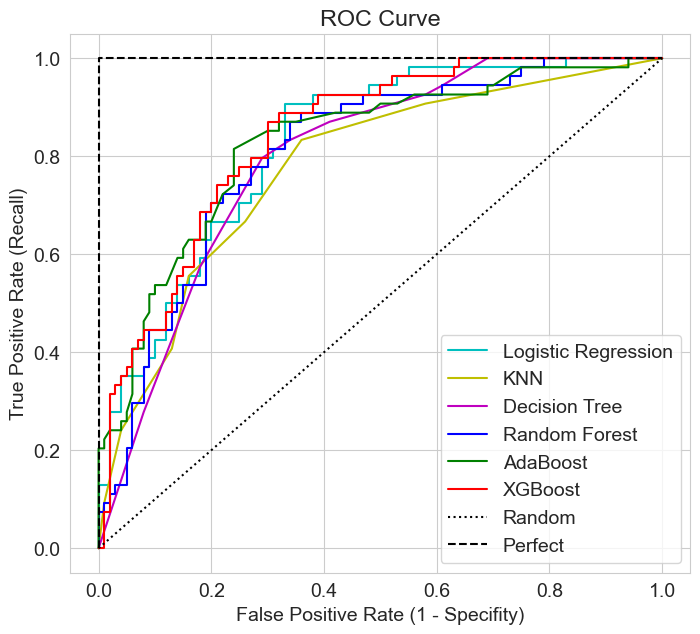

In [32]:
# Plot ROC curves
fpr_lr, tpr_lr, thr_lr = roc_curve(y_test, model_lr.predict_proba(X_test_logcat)[:,1])
fpr_knn, tpr_knn, thr_knn = roc_curve(y_test, model_knn.predict_proba(X_test_log)[:,1])
fpr_dtr, tpr_dtr, th_dtr = roc_curve(y_test, model_dtr.predict_proba(X_test_log)[:,1])
fpr_rf, tpr_rf, thr_rf = roc_curve(y_test, model_rf.predict_proba(X_test_log)[:,1])
fpr_ada, tpr_ada, thr_ada = roc_curve(y_test, model_ada.predict_proba(X_test_log)[:,1])
fpr_xgb, tpr_xgb, thr_xgb = roc_curve(y_test, model_xgb.predict_proba(X_test_log)[:,1])

fig = plt.figure(figsize=(8,7))
ax = fig.add_subplot()
plt.plot(fpr_lr, tpr_lr, 'c-', label = 'Logistic Regression')
plt.plot(fpr_knn, tpr_knn,'y-', label= 'KNN')
plt.plot(fpr_dtr, tpr_dtr,'m-', label = 'Decision Tree')
plt.plot(fpr_rf, tpr_rf,'b-', label = 'Random Forest')
plt.plot(fpr_ada, tpr_ada, 'g-', label = 'AdaBoost')
plt.plot(fpr_xgb, tpr_xgb, 'r-', label = 'XGBoost')
plt.plot([0,1],[0,1],'k:',label='Random')
plt.plot([0,0,1,1],[0,1,1,1],'k--',label='Perfect')
plt.legend(fontsize=14)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specifity)')
plt.ylabel('True Positive Rate (Recall)')
plt.show()

## ROC AUC Scores

In [33]:
# Find the model with the highest ROC AUC score
models = {'logistic regression' : model_lr,
          'KNN' : model_knn,
          'Decision Tree' : model_dtr,
          'Random Forest' : model_rf,
          'AdaBoost' : model_ada,
          'XGBoost': model_xgb}

best_score = 0
for key, model in models.items():
    if key == 'logistic regression':
        score = roc_auc_score(y_test, model.predict_proba(X_test_logcat)[:,1])
    else:
        score = roc_auc_score(y_test, model.predict_proba(X_test_log)[:,1])
    if score > best_score:
        best_score = score
        best_model = key

print(f"Model with the best ROC_AUC score: **{best_model}**")
print(f"- ROC AUC score: {round(best_score, 2)}")

Model with the best ROC_AUC score: **XGBoost**
- ROC AUC score: 0.84


The **XGBoost** classifier obtains the best ROC AUC score, in spite of the fact that the ROC curves looks quite similar.

## F1 Scores

In [34]:
# Find the model with the highest F1 score for a target recall of 80%
tpr = 0.80
best_score = 0
for key, model in models.items():
    if key == 'logistic regression':
        thr, _ = find_roc_threshold_tpr(model, X_test_logcat, y_test, tpr)
        score = f1_score(y_test, model.predict_proba(X_test_logcat)[:,1] >= thr)
    else:
        thr, _ = find_roc_threshold_tpr(model, X_test_log, y_test, tpr)
        score = f1_score(y_test, model.predict_proba(X_test_log)[:,1] >= thr)    
    if score > best_score:
        best_score = score
        best_model = key
        best_thr = thr
print(f"Model with the best F1 score for a recall of {100*tpr}%: **{best_model}**")         
print(f"- Threshold: {round(best_thr, 2)}")
print(f"- F1 score: {round(best_score, 2)}")

Model with the best F1 score for a recall of 80.0%: **AdaBoost**
- Threshold: 0.49
- F1 score: 0.71


According to this result, the **AdaBoost** classifer is the best model for a recall score of 80%.

## Generalization

In [39]:
# Find the model that achieves the lowest difference between the accuracy scores on the traning set and those on the test set. At the same time, the best model should also produce the highest accuracy score.
lowest_diff = 1
best_score_test = 0
for key, model in models.items():
    if key == 'logistic regression':
        score_train = accuracy_score(y_train, model.predict(X_train_logcat))
        score_test = accuracy_score(y_test, model.predict(X_test_logcat))
        diff = np.abs(score_train - score_test)
    else:
        score_train = accuracy_score(y_train, model.predict(X_train_log))
        score_test = accuracy_score(y_test, model.predict(X_test_log))
        diff = np.abs(score_train - score_test)    
    if (diff <= lowest_diff) and (score_test >= best_score_test):
        lowest_diff = diff
        best_score_test = score_test
        best_model = key

print(f"Model that best generalizes: **{best_model}**")

Model that best generalizes: **AdaBoost**


According to the above result, **AdaBoost** is the model that beest generalizes, as the accuracy scores on the training and test data are closer to each other.

## Confusion Matrix for a 80% Recall

In [36]:
# Find the false positive rate corresponding to a recall of 90% for AdaBoost
tpr = 0.80
thr, fpr = find_roc_threshold_tpr(model_ada, X_test_log, y_test, tpr)
print(f"Threshold for a recall of {100*tpr}%: {round(thr, 2)}")
print(f"False positive rate: {round(fpr, 2)}")

Threshold for a recall of 80.0%: 0.49
False positive rate: 0.24


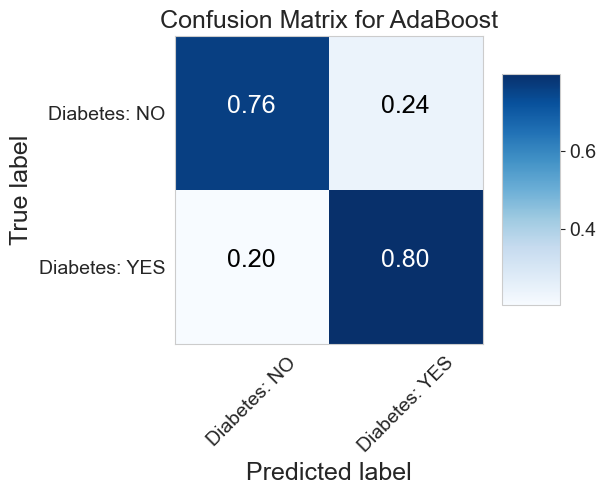

In [37]:
# Plot confusion matrix on the test set
y_test_pred = model_ada.predict_proba(X_test_log)[:,1] > (thr - 0.001)
cm = confusion_matrix(y_test, y_test_pred)
plot_confusion_matrix(cm, ['Diabetes: NO', 'Diabetes: YES'], normalize=True, title='Confusion Matrix for AdaBoost', cmap=plt.cm.Blues, figsize=(6,6))

# Conclusions
<a id='k-nearest-neighbors'><a>

In this notebook different machine-learning classifiers have been assessed for the Prima Indians Diabetes Database. According to the results, the boosting models produce highest performance. In particular, XGBoost achieves the highest ROC AUC, whereas AdaBoost generalizes better and achieves the highest F1 score (0.71) for a target recall of 80%. This recall results in a false positive rate of 24%, as shown in the confusion-matrix plot.